In [ ]:
import os
import json
from pathlib import Path
from typing import List, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'figure.max_open_warning': 0})
sns.set(style='whitegrid')

NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent
DOWNLOADS_DIR = ROOT_DIR / 'results_json'
OUTPUT_CSV = ROOT_DIR / 'results_summary.csv'

print('Notebook dir:', NOTEBOOK_DIR)
print('Downloads dir:', DOWNLOADS_DIR)



Notebook dir: c:\Users\pan\Desktop\web-sentiment-pipeline\notebooks
Downloads dir: c:\Users\pan\Desktop\web-sentiment-pipeline\downloads


In [81]:
def load_json_files_from_dir(directory: Path) -> List[Dict[str, Any]]:
    files = sorted(directory.glob('**/*.json'))
    records = []
    for f in files:
        try:
            raw = json.loads(f.read_text(encoding='utf-8'))
        except Exception as e:
            print(f'Failed to load {f}:', e)
            continue
        # attach filename for traceability
        raw['_source_file'] = str(f.relative_to(ROOT_DIR))
        records.append(raw)
    return records

records = load_json_files_from_dir(DOWNLOADS_DIR)
print(f'Found {len(records)} json files')

# show first item keys for debugging
if records:
    print('Sample keys:', list(records[0].keys()))



Found 27 json files
Sample keys: ['source_url', 'detected_source_language', 'raw_text_excerpt', 'cleaned_text_excerpt', 'translated_text_excerpt', 'sentiment', 'meta', '_source_file']


In [82]:
def extract_summary(record: Dict[str, Any]) -> Dict[str, Any]:
    # safe extraction with defaults
    src_url = record.get('source_url') or record.get('url') or None
    lang = record.get('detected_source_language') or record.get('language') or None
    s3_uri = record.get('s3_uri') or record.get('s3') or None

    # sentiment block extraction
    sentiment = record.get('sentiment') or {}
    overall = sentiment.get('overall_sentiment') or sentiment.get('overall') or None
    avg_scores = sentiment.get('average_scores') or {}
    pos = avg_scores.get('Positive') or avg_scores.get('positive') or None
    neg = avg_scores.get('Negative') or avg_scores.get('negative') or None
    neu = avg_scores.get('Neutral') or avg_scores.get('neutral') or None
    mixed = avg_scores.get('Mixed') or avg_scores.get('mixed') or None

    # processing time and excerpts
    processing_time = None
    if isinstance(record.get('meta'), dict):
        processing_time = record['meta'].get('processing_time_sec')
    if processing_time is None:
        processing_time = record.get('processing_time_sec') or None

    raw_excerpt = record.get('raw_text_excerpt') or ''
    translated_excerpt = record.get('translated_text_excerpt') or ''

    return {
        'source_file': record.get('_source_file'),
        'source_url': src_url,
        'detected_source_language': lang,
        'overall_sentiment': overall,
        'score_positive': pos,
        'score_negative': neg,
        'score_neutral': neu,
        'score_mixed': mixed,
        'processing_time_sec': processing_time,
        'raw_excerpt_len': len(raw_excerpt) if raw_excerpt else 0,
        'translated_excerpt_len': len(translated_excerpt) if translated_excerpt else 0,
        's3_uri': s3_uri
    }

summaries = [extract_summary(r) for r in records]

# make DataFrame
df = pd.DataFrame(summaries)
# assign an ID column (file index)
df.insert(0, 'id', range(1, len(df) + 1))

# some cleaning: convert score columns to numeric
for col in ['score_positive', 'score_negative', 'score_neutral', 'score_mixed', 'processing_time_sec']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# normalize language codes (lowercase)
if 'detected_source_language' in df.columns:
    df['detected_source_language'] = df['detected_source_language'].astype(str).str.lower().replace({'nan': None})

# save CSV
df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')
print('Saved summary CSV to', OUTPUT_CSV)

# quick peek
df.head(10)



Saved summary CSV to c:\Users\pan\Desktop\web-sentiment-pipeline\results_summary.csv


,id,source_file,source_url,detected_source_language,overall_sentiment,score_positive,score_negative,score_neutral,score_mixed,processing_time_sec,raw_excerpt_len,translated_excerpt_len,s3_uri
0,1,downloads\06c1948a97a4b35d3cfac6ccb88f94ed7495...,https://www.abc.net.au/news/2025-01-11/jannik-...,en,Neutral,0.002408,0.021953,0.974251,0.001388,1.778095,2000,2000,None
1,2,downloads\0dba9b3c5c5c198c7a433dedb5a30ac2d6ba...,https://www.ttplus.cn/publish/app/data/2024/08...,zh,Neutral,0.011421,0.004531,0.983970,0.000077,3.076749,2000,2000,None
2,3,downloads\1408d6cff0d0e442710e7fc670e1de66fadd...,https://www.jfdaily.com/news/detail?id=951537,zh,Neutral,0.013546,0.001755,0.984382,0.000317,2.021832,11,11,None
3,4,downloads\369f3dc8378e5364460de7572d9fbad81c38...,http://www.news.cn/sports/20250220/659f0556117...,zh,Neutral,0.100265,0.107025,0.790881,0.001829,1.442078,1335,2000,None
4,5,downloads\3ad2f56b6056516b2991062a6673f9a92c90...,https://www.tuttosport.com/news/tennis/2024/08...,it,Neutral,0.047101,0.003969,0.935516,0.013415,1.499403,2000,2000,None
5,6,downloads\5cbdc7e7f00c2b27111e08bd391758e4808d...,https://www.chinanews.com.cn/ty/2025/02-15/103...,zh,Neutral,0.002371,0.010121,0.987507,0.000001,2.012298,2000,2000,None
6,7,downloads\65b415bf22856df0c0d15353e3431119ce4d...,https://www.epochtimes.com/gb/25/2/15/n1443801...,zh,Neutral,0.003619,0.015784,0.979780,0.000817,0.945856,1413,2000,None
7,8,downloads\6ce34b2a06eb08f1f995aaa1015afba378cf...,https://www.startmag.it/sanita/cose-la-sostanz...,it,Neutral,0.000857,0.014708,0.983725,0.000711,0.911995,171,147,None
8,9,downloads\77768e8501c551125ecb0f89eeeef10e8093...,https://www.corrieredellosport.it/news/tennis/...,it,Neutral,0.027298,0.042007,0.715463,0.215232,1.184860,2000,2000,None
9,10,downloads\8136a641e3935d5c0e1274a3f511f65f1fa1...,https://www.npr.org/2025/02/15/nx-s1-5298666/t...,en,Neutral,0.004678,0.226731,0.668058,0.100533,1.195794,2000,2000,None


In [83]:
# df = pd.read_csv(OUTPUT_CSV)
df.info()
df=df.loc[lambda x:x["raw_excerpt_len"]>=1000]
OUTPUT_PLOTS_DIR = ROOT_DIR / 'analysis_plots'
OUTPUT_PLOTS_DIR.mkdir(exist_ok=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        27 non-null     int64  
 1   source_file               27 non-null     object 
 2   source_url                27 non-null     object 
 3   detected_source_language  27 non-null     object 
 4   overall_sentiment         27 non-null     object 
 5   score_positive            27 non-null     float64
 6   score_negative            27 non-null     float64
 7   score_neutral             27 non-null     float64
 8   score_mixed               27 non-null     float64
 9   processing_time_sec       27 non-null     float64
 10  raw_excerpt_len           27 non-null     int64  
 11  translated_excerpt_len    27 non-null     int64  
 12  s3_uri                    0 non-null      object 
dtypes: float64(5), int64(3), object(5)
memory usage: 2.9+ KB


Saved plots to c:\Users\pan\Desktop\web-sentiment-pipeline\analysis_plots


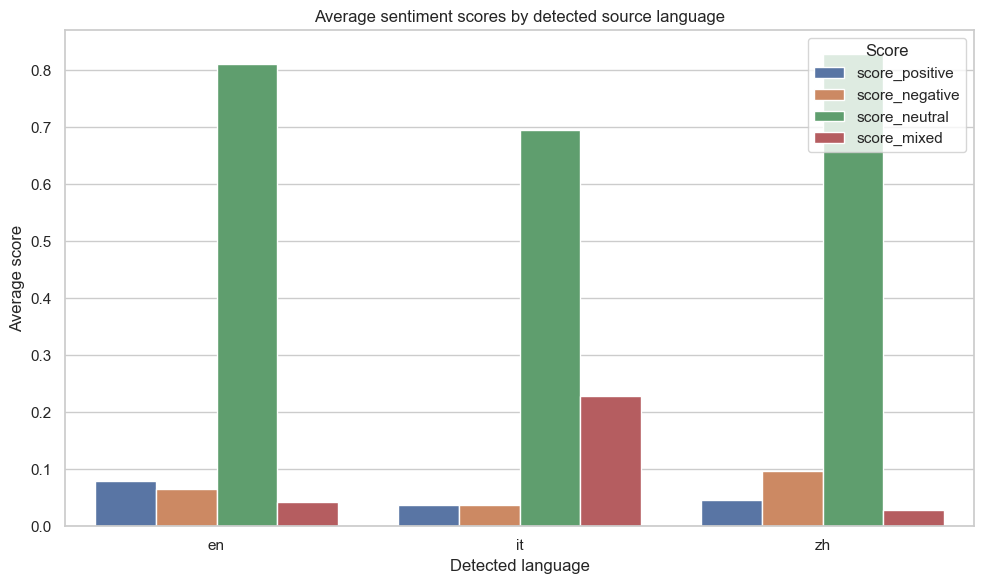

In [84]:
# group by language and compute mean scores
score_cols = ['score_positive', 'score_negative', 'score_neutral', 'score_mixed']
by_lang = df.groupby('detected_source_language')[score_cols].mean().reset_index()
by_lang = by_lang.sort_values('detected_source_language')
by_lang

# plot: grouped bar chart
plt.figure(figsize=(10, 6))
by_lang_melt = by_lang.melt(id_vars='detected_source_language', value_vars=score_cols,
                             var_name='score', value_name='mean_value')
ax = sns.barplot(data=by_lang_melt, x='detected_source_language', y='mean_value', hue='score')
ax.set_title('Average sentiment scores by detected source language')
ax.set_xlabel('Detected language')
ax.set_ylabel('Average score')
plt.legend(title='Score')
plt.tight_layout()
plt.savefig(OUTPUT_PLOTS_DIR / 'avg_scores_by_lang.png', dpi=200)
print('Saved plots to', OUTPUT_PLOTS_DIR)
plt.show()


Saved plots to c:\Users\pan\Desktop\web-sentiment-pipeline\analysis_plots


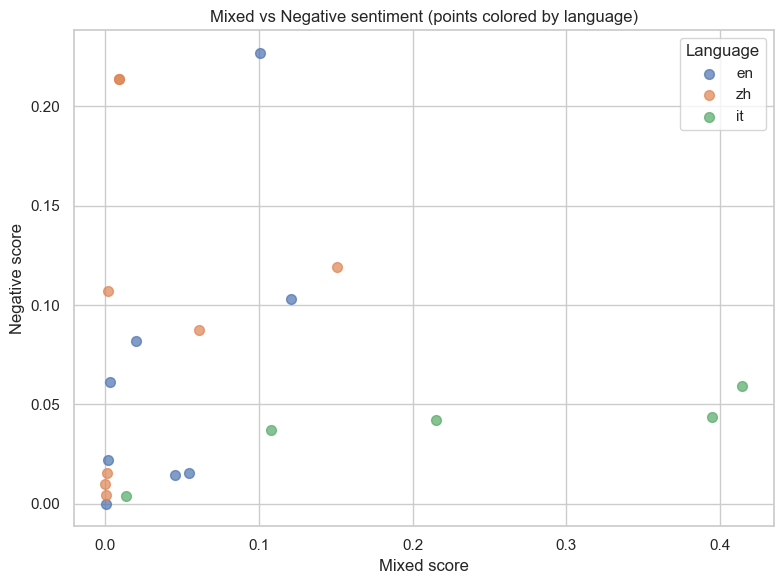

In [85]:
# filter rows with valid pos & neg
scatter_df = df.dropna(subset=['score_mixed', 'score_negative']).copy()

langs = scatter_df['detected_source_language'].fillna('unknown').unique()
palette = sns.color_palette('tab10', n_colors=len(langs))
color_map = dict(zip(langs, palette))

plt.figure(figsize=(8, 6))
for lang in langs:
    subset = scatter_df[scatter_df['detected_source_language'].fillna('unknown') == lang]
    plt.scatter(subset['score_mixed'], subset['score_negative'], label=str(lang), alpha=0.7, s=50)

plt.xlabel('Mixed score')
plt.ylabel('Negative score')
plt.title('Mixed vs Negative sentiment (points colored by language)')
plt.legend(title='Language')
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_PLOTS_DIR / 'Mixed_Negative_sentiment.png', dpi=200)
print('Saved plots to', OUTPUT_PLOTS_DIR)
plt.show()





Saved plots to c:\Users\pan\Desktop\web-sentiment-pipeline\analysis_plots


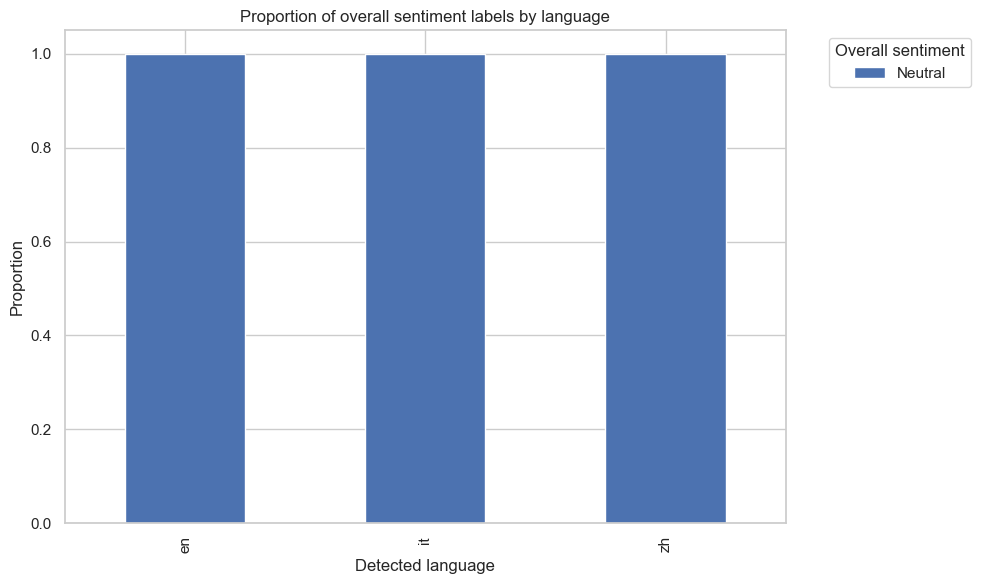

Saved plots to c:\Users\pan\Desktop\web-sentiment-pipeline\analysis_plots


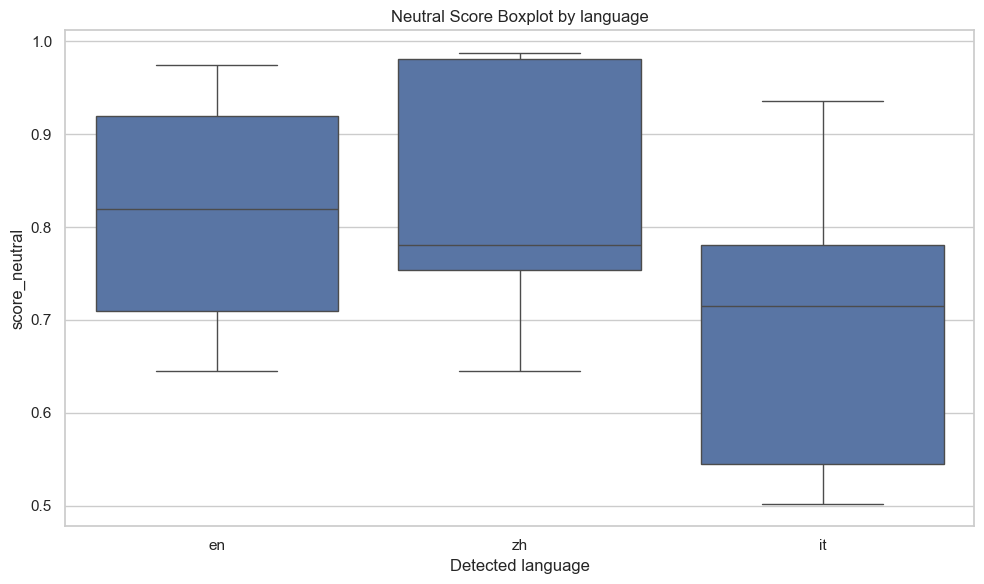

Saved plots to c:\Users\pan\Desktop\web-sentiment-pipeline\analysis_plots


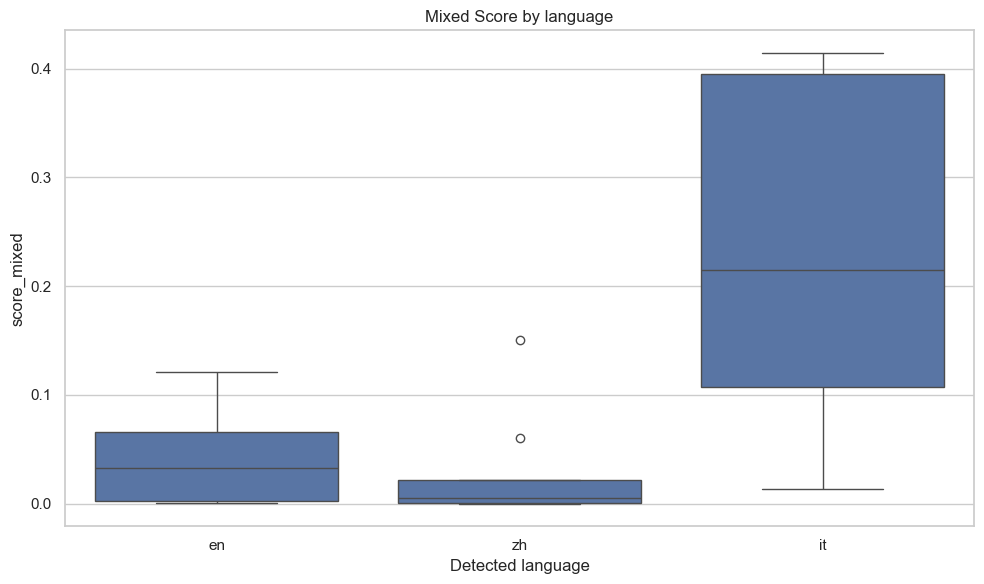

In [86]:
# overall_sentiment distribution per language (stacked bar)
sent_counts = df.groupby(['detected_source_language', 'overall_sentiment']).size().unstack(fill_value=0)

# normalize to fractions
sent_frac = sent_counts.div(sent_counts.sum(axis=1), axis=0)

sent_frac.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Proportion of overall sentiment labels by language')
plt.xlabel('Detected language')
plt.ylabel('Proportion')
plt.legend(title='Overall sentiment', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.savefig(OUTPUT_PLOTS_DIR / 'Overall_sentiment.png', dpi=200)
print('Saved plots to', OUTPUT_PLOTS_DIR)
plt.show()

# 7.2 score_neutral boxplot by language
plt.figure(figsize=(10,6))
plot_df = df.dropna(subset=['score_neutral']).copy()
sns.boxplot(data=plot_df, x='detected_source_language', y='score_neutral')
plt.title('Neutral Score Boxplot by language')
plt.xlabel('Detected language')
plt.ylabel('score_neutral')
plt.tight_layout()
plt.savefig(OUTPUT_PLOTS_DIR / 'neutral_boxplot.png', dpi=200)
print('Saved plots to', OUTPUT_PLOTS_DIR)
plt.show()

# 7.3 score_mixed boxplot by language
plt.figure(figsize=(10,6))
plot_df = df.dropna(subset=['score_mixed']).copy()
sns.boxplot(data=plot_df, x='detected_source_language', y='score_mixed')
plt.title('Mixed Score by language')
plt.xlabel('Detected language')
plt.ylabel('score_mixed')
plt.tight_layout()
plt.savefig(OUTPUT_PLOTS_DIR / 'mixed_boxplot.png', dpi=200)
print('Saved plots to', OUTPUT_PLOTS_DIR)
plt.show()

